In [1]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json

In [2]:
!nvidia-smi

Sun Mar  3 16:04:00 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:37:00.0 Off |                    0 |
| N/A   76C    P0            243W /  250W |   12996MiB /  40960MiB |    100%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# data_set = BallDataset()
data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_one_video=True)

batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [4]:
pre_frame, curr_frame, pre_boundary, curr_boundary = next(iter(data_loader))

In [5]:
pre_frame.shape

torch.Size([1, 3, 224, 224])

Text(0.5, 1.0, 'Curr Frame')

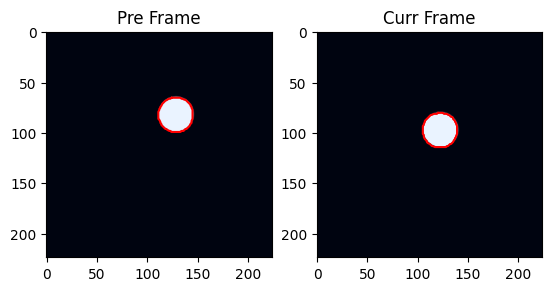

In [6]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [7]:
model = Model()

/zhome/32/f/202284/CV/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
def chamer_distance_loss(x, y):
    def bi_chamfer_distance(x, y):
        def chamfer_distance(a: torch.Tensor, b: torch.Tensor) -> float:
            total_min_dist = 0
            for i in range(a.shape[0]):
                total_min_dist += (b - a[i]).pow(2).sum(1).min(0)[0]
            return total_min_dist / a.shape[0]
        return chamfer_distance(x, y) + chamfer_distance(y, x)

    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += bi_chamfer_distance(x[i], y[i])

    return result / x.shape[0]

predict_boundary = pre_boundary.clone()
predict_boundary[:, :, 0] += 9
predict_boundary[:, :, 1] += -5
# print(curr_boundary - pre_boundary)
chamer_distance_loss(
    curr_boundary.float(),
    (predict_boundary).float()
)

tensor(506.1875)

In [9]:
pre_boundary.shape, curr_boundary.shape

(torch.Size([1, 80, 2]), torch.Size([1, 80, 2]))

In [10]:
def order_loss(x: torch.Tensor, y: torch.Tensor):
    def my_order_loss(x, y):
        min_loss = (x - y).abs().sum()
        for shift in range(1, x.shape[0]):
            # loss = (x - torch.roll(y, shifts=shift, dims=0)).pow(2).sum().sqrt()
            loss = (x - torch.roll(y, shifts=shift, dims=0)).abs().sum()
            min_loss = torch.min(min_loss, loss)
        return min_loss / x.shape[0]
        # return min_loss
        
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_order_loss(x[i], y[i])

    return result / x.shape[0]
predict_boundary = pre_boundary.clone()
predict_boundary[:, :, 0] += 8
predict_boundary[:, :, 1] += -5
order_loss(curr_boundary, predict_boundary)

tensor(34.4875)

In [11]:
torch.cuda.empty_cache()

In [12]:
model = model.cuda()
output = model(pre_frame.to("cuda"), curr_frame.to("cuda"), pre_boundary.to("cuda")).cpu()
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(232.9389, grad_fn=<DivBackward0>)

In [15]:
model = Model().to('cuda')
model_name = "uniform_model"
# data_set = BallDataset()
data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [16]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

0.6362524032592773

In [17]:
dict_loss = {}
num_epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
min_loss = 1e10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
for e in range(num_epochs):
    model.train()
    mean_loss = 0
    for pre_frame, curr_frame, pre_boundary, curr_boundary in tqdm(data_loader):
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        loss = loss_func(predic_boundary, curr_boundary.float())
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
        mean_loss += loss.item()
    mean_loss /= len(data_loader)
    dict_loss[e] = mean_loss
    scheduler.step()
    print(f"Epoch {e + 1}, Loss: {mean_loss}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:08<00:00,  2.18it/s]


Epoch 1, Loss: 16.11759735408582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.71it/s]


Epoch 2, Loss: 15.43218765760723


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.58it/s]


Epoch 3, Loss: 15.267548661482962


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch 4, Loss: 15.353868534690456


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.94it/s]


Epoch 5, Loss: 15.315802950608102


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.75it/s]


Epoch 6, Loss: 15.27095947767559


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.78it/s]


Epoch 7, Loss: 15.242393192492033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.22it/s]


Epoch 8, Loss: 15.218972507276034


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.75it/s]


Epoch 9, Loss: 15.192575831162301


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.74it/s]


Epoch 10, Loss: 15.161134619461862


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.71it/s]


Epoch 11, Loss: 15.127664315073114


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.98it/s]


Epoch 12, Loss: 15.135068491885537


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch 13, Loss: 15.160369371113024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.62it/s]


Epoch 14, Loss: 15.014510204917507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.49it/s]


Epoch 15, Loss: 15.299697675203022


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.64it/s]


Epoch 16, Loss: 14.8858659392909


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.34it/s]


Epoch 17, Loss: 14.663626595547324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.62it/s]


Epoch 18, Loss: 14.974926823063901


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.90it/s]


Epoch 19, Loss: 14.661876076146177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.72it/s]


Epoch 20, Loss: 14.601330255207262


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.78it/s]


Epoch 21, Loss: 14.371513191022371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.70it/s]


Epoch 22, Loss: 14.36056839792352


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.07it/s]


Epoch 23, Loss: 14.28884882675974


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.65it/s]


Epoch 24, Loss: 14.280616559480366


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.48it/s]


Epoch 25, Loss: 14.301597545021458


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.38it/s]


Epoch 26, Loss: 14.17370753539236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.74it/s]


Epoch 27, Loss: 14.057326919154116


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.71it/s]


Epoch 28, Loss: 14.042538090756064


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch 29, Loss: 13.899328181618138


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.87it/s]


Epoch 30, Loss: 13.754225705799303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.78it/s]


Epoch 31, Loss: 13.909304593738756


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.85it/s]


Epoch 32, Loss: 13.99190912748638


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch 33, Loss: 13.896816303855495


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.05it/s]


Epoch 34, Loss: 13.770073489138955


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.94it/s]


Epoch 35, Loss: 13.659316113120632


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.03it/s]


Epoch 36, Loss: 13.530754490902549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.72it/s]


Epoch 37, Loss: 13.610642081812808


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.89it/s]


Epoch 38, Loss: 13.6384899490758


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.76it/s]


Epoch 39, Loss: 13.568114682247764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.66it/s]


Epoch 40, Loss: 13.89259207876105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.90it/s]


Epoch 41, Loss: 13.53353500366211


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch 42, Loss: 13.821903103276304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.03it/s]


Epoch 43, Loss: 13.725142152685867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.02it/s]


Epoch 44, Loss: 13.752636708711323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.92it/s]


Epoch 45, Loss: 13.64722392433568


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.04it/s]


Epoch 46, Loss: 13.944393634796143


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.03it/s]


Epoch 47, Loss: 13.738157322532253


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.04it/s]


Epoch 48, Loss: 13.655880275525545


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.10it/s]


Epoch 49, Loss: 14.112017757014224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.77it/s]


Epoch 50, Loss: 13.6517172612642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.93it/s]


Epoch 51, Loss: 13.618265076687461


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.98it/s]


Epoch 52, Loss: 13.72045027582269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.62it/s]


Epoch 53, Loss: 13.877493306210166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.56it/s]


Epoch 54, Loss: 13.628024025967246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.58it/s]


Epoch 55, Loss: 13.593885773106626


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.45it/s]


Epoch 56, Loss: 13.551261098761307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.46it/s]


Epoch 57, Loss: 13.661529842175936


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.76it/s]


Epoch 58, Loss: 13.738703401465164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.62it/s]


Epoch 59, Loss: 13.860586015801681


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.03it/s]


Epoch 60, Loss: 13.776203406484504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]


Epoch 61, Loss: 13.765369339993125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.14it/s]


Epoch 62, Loss: 13.657106123472515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.10it/s]


Epoch 63, Loss: 13.615395696539627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.18it/s]


Epoch 64, Loss: 13.79752718774896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.88it/s]


Epoch 65, Loss: 13.707910713396574


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.78it/s]


Epoch 66, Loss: 13.526287279630962


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.13it/s]


Epoch 67, Loss: 13.517358754810534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.96it/s]


Epoch 68, Loss: 13.636204418383146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.80it/s]


Epoch 69, Loss: 13.777103775425962


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.17it/s]


Epoch 70, Loss: 13.382821434422544


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.09it/s]


Epoch 71, Loss: 13.73452675969977


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:05<00:00,  3.79it/s]


Epoch 72, Loss: 13.523572846462852


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.95it/s]


Epoch 73, Loss: 13.492460301047878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.01it/s]


Epoch 74, Loss: 13.683845520019531


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.00it/s]


Epoch 75, Loss: 13.705929128747238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.97it/s]


Epoch 76, Loss: 13.763586822308993


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.88it/s]


Epoch 77, Loss: 13.489697556746634


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.09it/s]


Epoch 78, Loss: 13.768785100234183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.99it/s]


Epoch 79, Loss: 13.70372328005339


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.79it/s]


Epoch 80, Loss: 13.580317748220343


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.74it/s]


Epoch 81, Loss: 13.562589394418817


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.53it/s]


Epoch 82, Loss: 13.704492443486265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.67it/s]


Epoch 83, Loss: 13.712283611297607


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.66it/s]


Epoch 84, Loss: 13.530297304454603


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.79it/s]


Epoch 85, Loss: 13.579967574069375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.90it/s]


Epoch 86, Loss: 13.551286973451314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.03it/s]


Epoch 87, Loss: 13.564758426264712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.01it/s]


Epoch 88, Loss: 13.71802063992149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.68it/s]


Epoch 89, Loss: 13.584592367473402


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.18it/s]


Epoch 90, Loss: 13.49892204686215


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.55it/s]


Epoch 91, Loss: 13.875649251435933


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.01it/s]


Epoch 92, Loss: 13.49739082236039


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.02it/s]


Epoch 93, Loss: 13.544653666646857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.65it/s]


Epoch 94, Loss: 13.534044290843763


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.49it/s]


Epoch 95, Loss: 13.579466618989644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.30it/s]


Epoch 96, Loss: 13.882594961869088


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.66it/s]


Epoch 97, Loss: 13.713176827681693


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.34it/s]


Epoch 98, Loss: 13.59485596104672


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 11.21it/s]


Epoch 99, Loss: 13.506761174452933


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 10.84it/s]

Epoch 100, Loss: 13.904924944827432


In [22]:
# save loss
with open(f"./log/{model_name}_{loss_name}.json", "w") as f:
    json.dump(dict_loss, f)

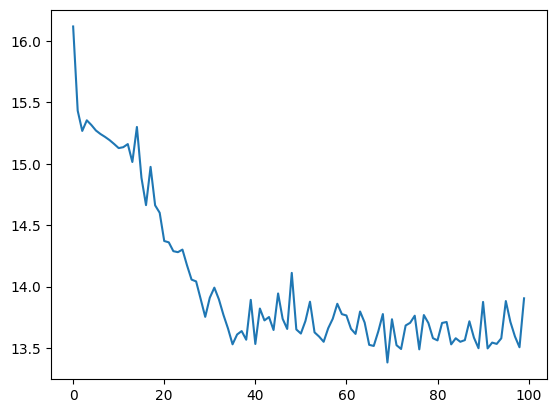

In [23]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))

In [53]:
model = Model()
model_name = "uniform_model"
# model_name = "simplify_model"
loss_name = "order_loss"
# loss_name = "chamer_distance_loss"
model.load_state_dict(torch.load(f"./models/{model_name}_{loss_name}.pth"))
model = model.to("cuda")

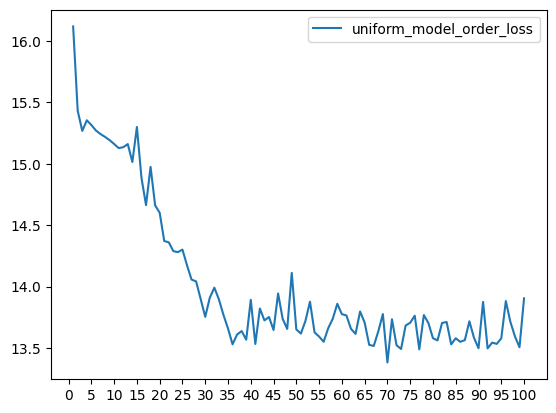

In [24]:
# load the loss
with open(f"./log/{model_name}_{loss_name}.json", "r") as f:
    dict_loss = json.load(f)
# plot the loss
plt.plot(np.array(list(dict_loss.keys())).astype(int) + 1, list(dict_loss.values()), label=f"{model_name}_{loss_name}")
# plt.legend(loc="lower right")
plt.legend()
# set the xticks
plt.xticks(np.arange(0, 101, 5))
plt.show()

In [43]:
class DAVIS_test(torch.utils.data.Dataset):
    def __init__(self, video_name: str, is_uniform=True):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        if is_uniform:
            with open("./uniform_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        else:
            with open("./simplify_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        
        self.data = tmp_data[video_name]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, sgm_path, boundary = self.data[idx]
        img = Image.open(img_path)
        sgm = get_gray_image(sgm_path)
        img = self.transform(img)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

In [20]:
class Balltest(torch.utils.data.Dataset):
    def __init__(self, json_path="./ball/uniform_samples_80.json"):
        self.json_path = json_path
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.data = json.load(open(json_path, "r"))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, boundary = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        sgm = get_gray_image(img_path)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 18.58it/s]


0.31823725040908635

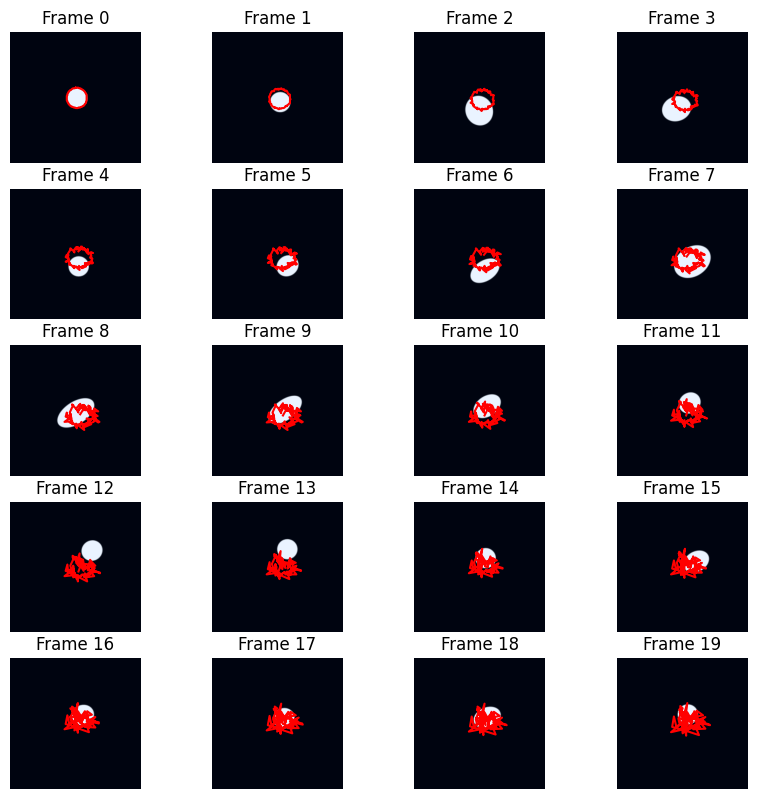

In [21]:
def test_model_one_video(model, test_dataset: torch.utils.data.Dataset, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    plt.figure(figsize=(10, 20))
    plt.subplot(10, 4, 1)
    plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
    plt.plot(pre_boundary[:, 0], pre_boundary[:, 1], 'r')
    plt.axis('off')
    plt.title('Frame 0')
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 1
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        # print(pre_img.shape, img.shape, pre_boundary.shape)
        with torch.no_grad():
            boundary_offset = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            # pre_boundary[:, 0] += 9
            # print(boundary_offset)
            pre_boundary = pre_boundary + boundary_offset.squeeze(0)
            pre_boundary = pre_boundary.int()
            pre_boundary = torch.clamp(pre_boundary, 0, 223)
            # print(pre_boundary.cpu() - boundary)
            # pre_boundary = boundary.squeeze(0).to(device)
            pre_img = img
            if i % interval == 0:
                plt.subplot(10, 4, i // interval + 1)
                # plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
# if model_name == "uniform_model":
#     test_dataset = DAVIS_test("bear", is_uniform=True)
# else:
#     test_dataset = DAVIS_test("bear", is_uniform=False)
# test_dataset = Balltest()
test_dataset = Balltest("ellipse/uniform_samples_80.json")
test_model_one_video(model, test_dataset)